In [1]:
import xarray as xr
import numpy as np
import os 
import matplotlib.pyplot as plt 
import h5py
from matplotlib.path import Path
import pandas as pd 
import sectionate as sec
import regionate as reg
from xgcm import Grid
import pickle 
import dask 
from dask.distributed import Client, LocalCluster
from scipy.ndimage import uniform_filter1d
import math, psutil
%matplotlib inline

In [2]:
# import dataset with mass-weighted velocity and theta for January 2007. Grid coords have been interpolated 
# to center-outer format to be usable as input to regionate package 

os.chdir('/data/globus/zkaufman')
with open("ds_MASS_xyouter_withtime.pkl", "rb") as f:
   ds_xyouter = pickle.load(f)

ds_xyouter

<xarray.Dataset> Size: 2TB
Dimensions:       (date: 31, RC: 225, YC: 2343, XO: 8641, YO: 2344, XC: 8640,
                   RF: 226)
Coordinates: (12/17)
  * date          (date) float32 124B 1.051e+06 1.053e+06 ... 1.094e+06
  * XC            (XC) float32 35kB 0.02083 0.0625 0.1042 ... 359.9 359.9 360.0
    DXC           (XC) float32 35kB 363.8 363.8 363.8 ... 363.8 363.8 363.8
  * XO            (XO) float32 35kB 0.0 0.04167 0.08333 ... 359.9 360.0 360.0
    DXG           (XO) float32 35kB 363.5 363.5 363.5 ... 363.5 363.5 363.5
  * YC            (YC) float32 9kB -85.5 -85.49 -85.48 ... -55.07 -55.05 -55.03
    ...            ...
  * RF            (RF) float32 904B 0.0 -1.4 -2.835 ... -5.904e+03 -5.954e+03
    DRF           (RC) float32 900B 1.4 1.435 1.471 1.508 ... 50.0 50.0 50.0
    geolon        (XC, YC) float32 81MB 0.02083 0.02083 0.02083 ... 360.0 360.0
    geolat        (XC, YC) float32 81MB -85.5 -85.49 -85.48 ... -55.05 -55.03
    geolon_c      (XO, YO) float32 81MB 0.0 0.0 0.0 0.0 ... 360.0 360.0 360.0
    geolat_c      (XO, YO) float32 81MB -85.5 -85.49 -85.48 ... -55.04 -55.02
Data variables:
    UVEL          (date, RC, YC, XO) float32 565GB dask.array<chunksize=(1, 40, 512, 512), meta=np.ndarray>
    VVEL          (date, RC, YO, XC) float32 565GB dask.array<chunksize=(1, 40, 512, 512), meta=np.ndarray>
    THETA         (date, RC, YC, XC) float32 565GB dask.array<chunksize=(1, 40, 512, 512), meta=np.ndarray>
    deptho_on_uv  (YO, XO) float32 81MB 0.0 0.0 0.0 ... 1.871e+03 1.744e+03
    areacello     (YC, XC) float32 81MB 3.638e+05 3.638e+05 ... 7.05e+06

In [3]:
# set up dask client


total = psutil.virtual_memory().total
usable = int(total * 0.7)              # reserve ~30%
mem_per_worker = 8 * 1024**3           # 8 GB
n_workers = max(8, min(24, usable // mem_per_worker))


# good HPC defaults
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

cluster = LocalCluster(
    n_workers=n_workers,
    threads_per_worker=1,
    memory_limit=str(mem_per_worker),
    local_directory="/tmp/dask-${USER}",
    dashboard_address=":8787",            # force 8787 (or ":0" for random)
    processes=True
)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 192.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46643,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40805,Total threads: 1
Dashboard: http://127.0.0.1:37645/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:43779,


In [4]:
# build xGCM grid object 

coords={'X': {'center': 'XC', 'outer': 'XO'},
                        'Y': {'center': 'YC', 'outer': 'YO'}}
boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
grid = Grid(ds_xyouter,coords=coords,boundary=boundary,autoparse_metadata=False)

In [6]:
U  = ds_xyouter["UVEL"]              # (RC, YC, XO)
V  = ds_xyouter["VVEL"]              # (RC, YO, XC)
AREA = ds_xyouter["areacello"]       # (YC, XC)

#  “normal” chunks to keep graphs small
NORMAL = {"date": 1, "RC": 40, "YC": 512, "XC": 512, "XO": 512, "YO": 512}

# chunk dx, dy for calculating spatial gradients 
DXC = ds_xyouter["DXC"].chunk({"XC": NORMAL["XC"]})
DYC = ds_xyouter["DYC"].chunk({"YC": NORMAL["YC"]})
DXG = ds_xyouter["DXG"].chunk({"XO": NORMAL["XO"]})
DYG = ds_xyouter["DYG"].chunk({"YO": NORMAL["YO"]})

# chunk AREA since it wasn't chunked before
AREA = AREA.chunk({"YC": NORMAL["YC"], "XC": NORMAL["XC"]})

In [ ]:
# calculate x and y components of mass flux convergence on cell outer faces 

# Fx: XO -> XC (center)
U_c = grid.interp(U.chunk({"XO": -1}), "X", to="center")
U_c = U_c.chunk({"XC": NORMAL["XC"], "YC": NORMAL["YC"]})

# Fy: YO -> YC (center)
V_c = grid.interp(V.chunk({"YO": -1}), "Y", to="center")
V_c = V_c.chunk({"YC": NORMAL["YC"], "XC": NORMAL["XC"]})

# ---- diffs need contiguous axis too ----
# d/dx at u-faces (X): input uses XC, so make XC contiguous before diff
dU_dx_on_u = grid.diff(U_c.chunk({"XC": -1}), "X") / DXG
dU_dx_on_u = dU_dx_on_u.astype("float32").chunk({"YC": NORMAL["YC"], "XO": NORMAL["XO"]})

# d/dy at v-faces (Y): input uses YC, so make YC contiguous before diff
dV_dy_on_v = grid.diff(V_c.chunk({"YC": -1}), "Y") / DYG
dV_dy_on_v = dV_dy_on_v.astype("float32").chunk({"YO": NORMAL["YO"], "XC": NORMAL["XC"]})

# interpolate AREA to velocity grid  
AREA_on_u = grid.interp(AREA.chunk({"XC": -1}), "X")          # (RC, YC, XO)
AREA_on_u = AREA_on_u.chunk({"YC": NORMAL["YC"], "XO": NORMAL["XO"]})
AREA_on_v = grid.interp(AREA.chunk({"YC": -1}), "Y")          # (RC, YO, XC)
AREA_on_v = AREA_on_v.chunk({"YO": NORMAL["YO"], "XC": NORMAL["XC"]})

# get mass flux convergence (m^3 / s)
thick = ds_xyouter['DRF']
ds_xyouter['U_adx'] = dU_dx_on_u*thick*AREA_on_u
ds_xyouter['V_ady'] = dV_dy_on_v*thick*AREA_on_v


In [8]:
# calculate full mass flux convergence on cell centers 

# d/dx at cell centers 
dU_dx = (grid.diff(U.chunk({"XO": -1}), "X") / DXC).astype("float32")
dUx_dx = dU_dx.chunk({"YC": NORMAL["YC"], "XC": NORMAL["XC"]})
# d/dy at cell centers 
dV_dy = (grid.diff(V.chunk({"YO": -1}), "Y") / DYC).astype("float32")
dV_dy = dV_dy.chunk({"YC": NORMAL["YC"], "XC": NORMAL["XC"]})

adv_mass_flux = (-(dU_dx + dV_dy)).astype("float32")#.persist()

# get mass flux convergence (m^3 / s)
thick = ds_xyouter['DRF']
ds_xyouter['Mass_advection_xy'] = adv_mass_flux*thick*AREA


/home/zkaufman/miniconda3/envs/base_env/lib/python3.12/site-packages/dask/array/core.py:5003: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(


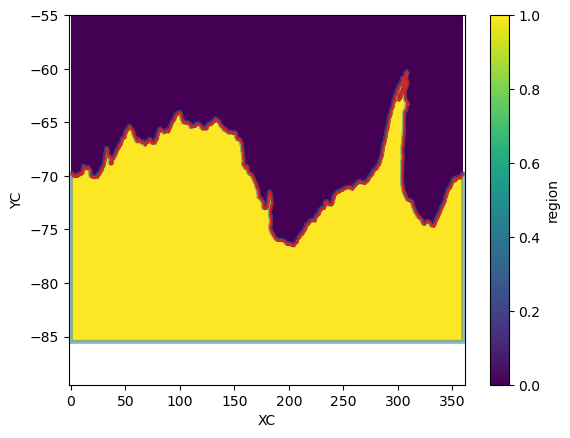

In [9]:
# using bathymetry, build antarctic margin regionate region from the 1000m isobath 

ds_xyouter["deptho"] = grid.interp(grid.interp(ds_xyouter.deptho_on_uv, "X"), "Y")
mask = (ds_xyouter.deptho <= 1000.) 
region_dict = reg.MaskRegions(mask, grid).region_dict
region = region_dict[0] # pick out the first region, corresponding to the longest contour

name = "Antarctic margin"
region = reg.GriddedRegion(
    name,
    region.lons_c[::-1], # reverse direction so that the boundary has a west-to-east orientation
    region.lats_c[::-1],
    grid,
    ij=(region.i_c[::-1], region.j_c[::-1])
)

idx_without_border = (
    (region.lons_c != ds_xyouter.XO.min().values) &
    (region.lons_c != ds_xyouter.XO.max().values) &
    (region.lats_c != np.min(region.lats_c))
)

region.mask.plot(x="XC")
plt.plot(region.lons_c, region.lats_c, "C0-", alpha=0.5, markersize=1, lw=3, label="full region boundary")
plt.plot(region.lons_c[idx_without_border], region.lats_c[idx_without_border], "C3.-", lw=0.5, markersize=0.1, label="isobath only (ignoring grid boundaries)")
plt.ylim(-89.5, -55)
plt.xlim(-2, 362);

In [ ]:
# calculate and load normal mass fluxes at region boundary 

convergent_mass_transport = sec.convergent_transport(
    grid,
    region.i_c[:-1][idx_without_border],
    region.j_c[:-1][idx_without_border],
    utr="U_adx",
    vtr="V_ady",
    layer='RC',
    interface=None,
    outname="conv_mass_transport"
    )['conv_mass_transport'].sum("RC").compute()

In [13]:
# calculate and load volume integral of column mass fluxes in each grid cell (within the region)

dmassdt_dynamics = (ds_xyouter['Mass_advection_xy']).sum('RC').squeeze()
dmassdt_dynamics = dmassdt_dynamics.where(dmassdt_dynamics!=0.).squeeze().compute()
masstransp_volumeintegral = dmassdt_dynamics.where(region.mask).sum(['XC', 'YC']).squeeze()

/home/zkaufman/miniconda3/envs/base_env/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 87.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [14]:
# check if the summed, normal mass fluxes balance with the volume integral (in the time mean)

print('Normal to shelf boundary (surface integral, Sv):')
print(np.cumsum(convergent_mass_transport.mean(dim='date').values)[-1] *1e-6)

print('Volume integral (Sv):')
print(masstransp_volumeintegral.mean(dim='date').values *1e-6)

Normal to shelf boundary (surface integral, Sv):
203.1859983877651
Volume integral (Sv):
-670.4562559999999


Text(0.5, 1.0, 'On-Shelf Mass Transport, January 2007')

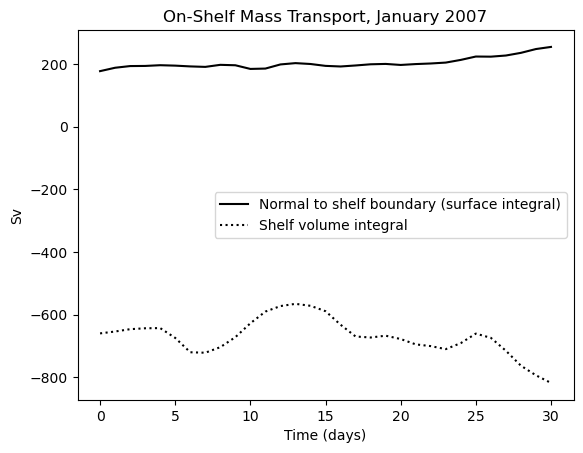

In [15]:
# visualize temporal variability in both mass transport calculations for one month 

plt.plot(convergent_mass_transport.sum('sect').values *1e-6,'k',label='Normal to shelf boundary (surface integral)')
plt.plot(masstransp_volumeintegral.values *1e-6,'k:',label='Shelf volume integral')
plt.ylabel('Sv')
plt.xlabel('Time (days)')
plt.legend()
plt.title('On-Shelf Mass Transport, January 2007')